# Etudes Statistiques
## Librairies et constante

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *
import time

minSommet = 10
maxSommet = 100
step = 10

nbIteration = 50

xSize = 100
ySize = 100

fluctuation = 1
fluctuationWeight = 1

## Fonctions : Generation des sommets

In [16]:
def GeneratorCity(nb_city: int = 10, size_map: tuple = (100, 100)) -> list:
    """
    Return a list of cities with random coordinates and their utility

    Arguments:
        nb_city: Number of cities
        size_map: Area of the map in this format : (max_abscissa, max_ordinate)
        display: Draw a diagram of the situation

    Return:
        An array of cities with the abscissa, ordinate and the use of each cities ;
        0 means "This city is not important" ;
        1 means "This city must be delivered" ;
        2 means "This city is the depository" ;
    """

    # Randomization of points
    abscissa = random.sample(range(0, size_map[0]), nb_city)
    ordinate = random.sample(range(0, size_map[1]), nb_city)

    # Return the list of coordinate
    return [[abscissa[i],ordinate[i]] for i in range(nb_city)]

def DefinitionCity(cities: list) -> list:
    """
    Defines the type of cities

    Arguments:
        cities: The cities
        no_delivered: Removal of undelivered cities

    Return:
        The list of cities
    """

    # Define the kind of city
    delivered = [1] * len(cities)

    # Define a repository
    delivered[random.randint(1, len(cities)) - 1] = 2

    # Return the list of city
    return [[cities[i][0],cities[i][1],delivered[i]] for i in range(len(cities))]

def GeneratorGraph(cities: list, fluctuation: int = 10, fluctuation_weight: int = 10):
    """
    Return the graph of the instance

    Arguments:
        cities: The coordinate from the city in this format : [max_abscissa, max_ordinate]
        fluctuation: The rate of fluctuation of the cost of the arcs
        fluctuation_weight: The fluctuation amplitude of the cost of the arcs

    Return:
        A matrix of size [nb_city, nb_city, 3]
    """

    # Initialization of the graph matrix
    generator = np.array([[(0, 0, 0)] * len(cities)] * len(cities))

    # For each element of the graph
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j:
                # Traffic randomization
                if fluctuation == 0:
                    arc_fluctuation = 0
                else:
                    arc_fluctuation = random.randrange(0, fluctuation)
                # Calculation of the distance between two points
                arc_min_cost = sqrt(pow(cities[i][0] - cities[j][0], 2) + pow(cities[i][1] - cities[j][1], 2))
                # Randomization of the traffic amplitude
                if fluctuation_weight == 0:
                    arc_fluctuation_weight = 0
                else:
                    arc_fluctuation_weight = random.randrange(0, fluctuation_weight) * arc_min_cost
                
                # Completion of the matrix
                generator[i][j] = (arc_fluctuation, arc_fluctuation_weight, arc_min_cost)

    # Return the matrix
    return generator

## Fonction : Calcul des distances

In [17]:
def EnergieSum(graph: np.array([[()]]), cycle: tuple) -> float:
    """
    Calculation of the energies of the graph

    Arguments:
        graph: The graph

    Return:
        The energie of the graph
    
    """
    # Energy initialization
    energie = 0

    # For each point of the graph
    for i in range(len(cycle) - 1):
        # Add the energy of the path
        energie += CalculArc(graph, energie, (cycle[i], cycle[i+1]))
    
    return energie

def CalculArc(graph: np.array([[()]]), time: float, arc: tuple) -> float:
    """
    Calculates the time needed to use an arc at a given time

    Arguments:
        graph: The graph
        time: The moment the arc is use
        arc: A tuple with (start node, end node)
    
    Return:
        The time used
    """

    # Recovering data from the arc
    a = graph[arc[0]-1][arc[1]-1][0]
    c = graph[arc[0]-1][arc[1]-1][1]
    d = graph[arc[0]-1][arc[1]-1][2]

    # Only if a fluctuation is present
    if a != 0 and c != 0:
        # Calculation of the interval of the function
        intervalle = 2*sqrt(c)/sqrt(a)
        # Time transposition on the function
        time = time % intervalle
        # Calculation of the cost of the arc
        return -1 * a * pow(time - sqrt(c)/sqrt(a), 2) + c + d
    
    else:
        # Return the minimum cost
        return d

## Fonctions : Nearest neightbor

In [18]:
def NearestNeightbor(graph: np.array([[()]]), time: float, start_city: int, cities_available: list):
    """
    Get the nearest neightbor city which isn't use

    Arguments:
        graph: The graph
        time: The start time
        start_city: The start city
        cities_available: The list of cities which are available

    Return:
        The nearest neightbor city and the add time needed
    """

    nearest_neightbor = cities_available[0]
    lowest_time = CalculArc(graph, time, (start_city, cities_available[0]))

    for cities in cities_available[1:]:
        current_time = CalculArc(graph, time, (start_city, cities))
        if current_time < lowest_time:
            lowest_time = current_time
            nearest_neightbor = cities

    if len(cities_available) > 1:
        return [nearest_neightbor] + NearestNeightbor(graph, time + lowest_time, nearest_neightbor, [city for city in cities_available if city != nearest_neightbor])
    else:
        return [nearest_neightbor]

## Fonctions : Recuit simulé

In [19]:
def Recuit(graph: np.array([[()]]), cycle: list, energie: float):
    """
    Find the shortest cycle using the simulated annealing algorithm

    Arguments:
        graph: The graph with the weight
        cycle: A valid path
        energie: The cost of the cycle
        temperature: The coefficient of research
        tempmin: The limit of temperature
        multipli: The modification coefficient

    Return:
        A cycle and the energie associated
    """
    nbPoints = cycle.__len__()-2
    temperature = 0.5
    condition = True
    while(condition):
        nbChanges = 0
        for _ in range(nbPoints*100):
            # Create a new path
            newP = BasicChange(cycle, nbPoints)

            # Calculate the cost of the new path
            newE = EnergieSum(graph, newP)

            # If the new path is bether
            if newE<energie :
                # Change the best record
                energie = newE
                cycle = newP
                nbChanges += 1
                if(nbChanges == 10*nbPoints):
                    break

            elif newE != energie and random.random() < exp(-(newE-energie)/temperature):
                energie = newE
                cycle = newP
        temperature *= 0.9
        condition = nbChanges != 0

    return cycle, energie

def BasicChange(cycle: tuple, nbPoints):
    """
    Select a segment of the cycle and either reverse it or splice it elsewhere all at random

    Arguments:
        cycle: The cycle

    Return:
        The new cycle
    """

    # Index of the first element
    rand1 = random.randint(1, nbPoints)

    # Loop to avoid rand1 == rand2
    cond = True
    while(cond):
        # Select the second element
        rand2 = random.randint(1, nbPoints)
        cond = rand1 == rand2

    # Format the random numbers so that rand1 is less than rand2
    if rand1>rand2 :
        rand1, rand2 = rand2, rand1

    # Selected segment
    segment = cycle[rand1:rand2]

    # Choose at random which change will be made
    if(random.randint(0,1)):
        # Reverse the segment
        segment.reverse()
        return cycle[:rand1]+segment+cycle[rand2:]

    else:
        # Move the segment
        reste = cycle[:rand1]+cycle[rand2:]
        # Loop to avoid rand1 == rand2
        cond = True
        while(cond):
        # Select the second element
            rand3 = random.randint(1, len(reste) - 1)
            cond = rand1 == rand3
        
        return reste[:rand3]+segment+reste[rand3:]

## Statistiques
### Génération des sommets

In [20]:
# Seed of generation
random.seed(7)
#random.seed(time.time_ns())

Sommets = []
pointNbChange=floor((maxSommet-minSommet)/step)+2
for nbSommet in range(1, pointNbChange):
    Sommets.append([])
    
    for itération in range(nbIteration):
        # Generation of cities
        points = DefinitionCity(GeneratorCity(nbSommet*step, (xSize,ySize)))

        # Generation of the graph
        graph = GeneratorGraph(points, fluctuation, fluctuationWeight)

        # Create a path with every cities which need to be delivered
        cycle = []
        for i in range(len(points)):
            if points[i][2] == 1:
                cycle += [i+1]

        # Get the repository point
        
        i = 0
        while points[i][2] != 2:
            i += 1
        repository = i + 1
        
        # Add the depository on the path
        cycle = [repository] + cycle + [repository]

        Sommets[nbSommet-1].append((graph, repository, points, cycle))

### Nearest

In [21]:
ResultsNearest = []

for nbSommet in range(1, pointNbChange):
    ResultsNearest.append([])

    for itération in range(nbIteration):
        start_time = time.time_ns()
        # print([x+1 for x, y in enumerate(Sommets[nbSommet-minSommet][itération][2]) if y[2] == 1])
        cycleResult = [Sommets[nbSommet-1][itération][1]] \
            + NearestNeightbor(Sommets[nbSommet-1][itération][0], 0, Sommets[nbSommet-1][itération][1], [x+1 for x, y in enumerate(Sommets[nbSommet-1][itération][2]) if y[2] == 1])\
                 + [Sommets[nbSommet-1][itération][1]]

        stop_time = time.time_ns()

        ResultsNearest[nbSommet-1].append((stop_time-start_time, EnergieSum(Sommets[nbSommet-1][itération][0], cycleResult), cycleResult))

### Recuit simulé

In [22]:
ResultsRecuit = []

for nbSommet in range(1, pointNbChange):
    ResultsRecuit.append([])

    for itération in range(nbIteration):
        start_time = time.time_ns()

        # Calculate the energie of the initial path
        energie = EnergieSum(Sommets[nbSommet-1][itération][0], Sommets[nbSommet-1][itération][3])
        cycleResult, energieResult = Recuit(Sommets[nbSommet-1][itération][0], Sommets[nbSommet-1][itération][3], energie)

        stop_time = time.time_ns()

        ResultsRecuit[nbSommet-1].append((stop_time-start_time, energieResult))

In [23]:
print(ResultsRecuit.__len__())

10


### Nearest + Recuit simulé

In [24]:
ResultsCombo = []

for nbSommet in range(1, pointNbChange):
    ResultsCombo.append([])

    for itération in range(nbIteration):
        start_time = time.time_ns()

        # Calculate the energie of the initial path
        energie = EnergieSum(Sommets[nbSommet-1][itération][0], ResultsNearest[nbSommet-1][itération][2])
        cycleResult, energieResult = Recuit(Sommets[nbSommet-1][itération][0], ResultsNearest[nbSommet-1][itération][2], energie)

        stop_time = time.time_ns()

        ResultsCombo[nbSommet-1].append((stop_time-start_time, energieResult))

## Graphes

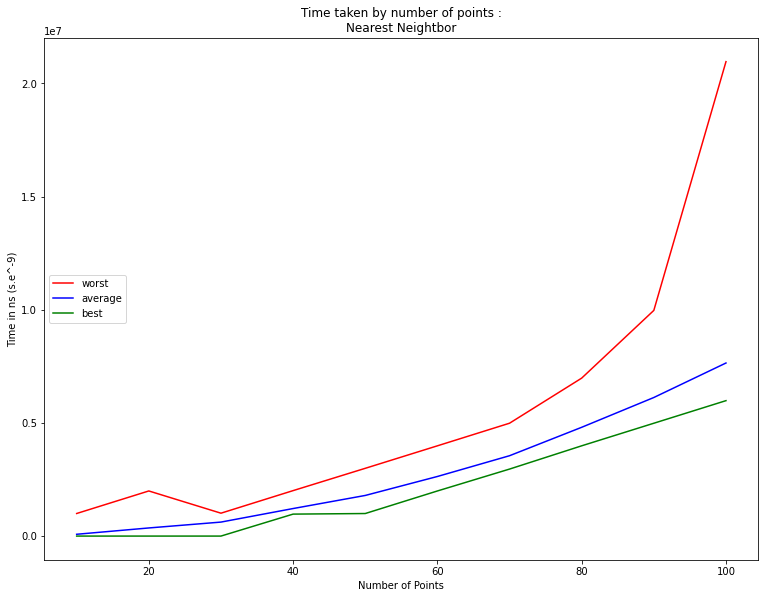

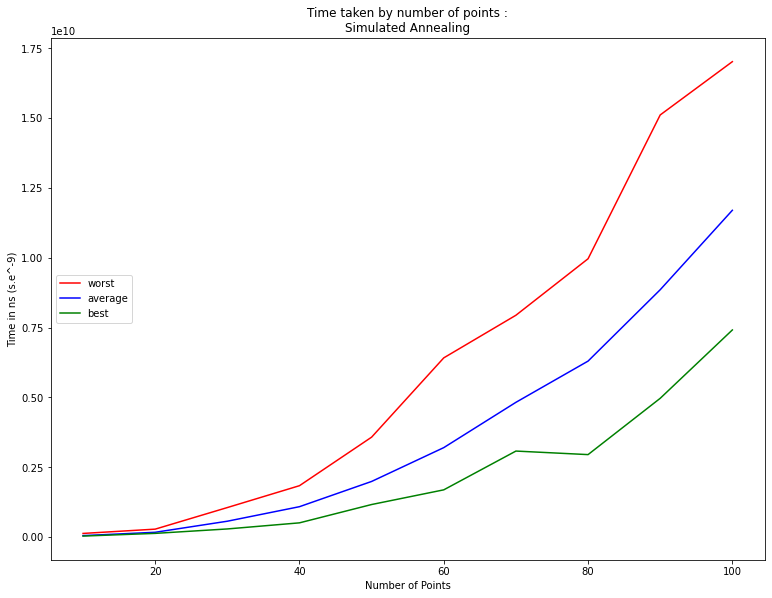

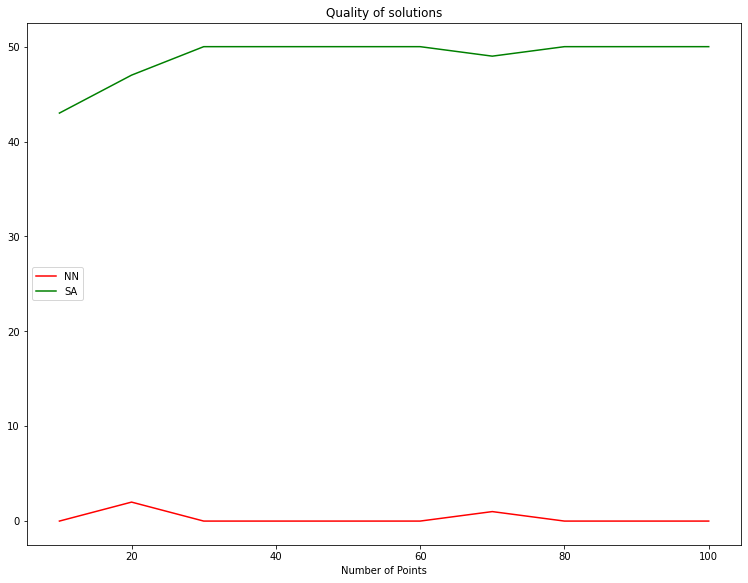

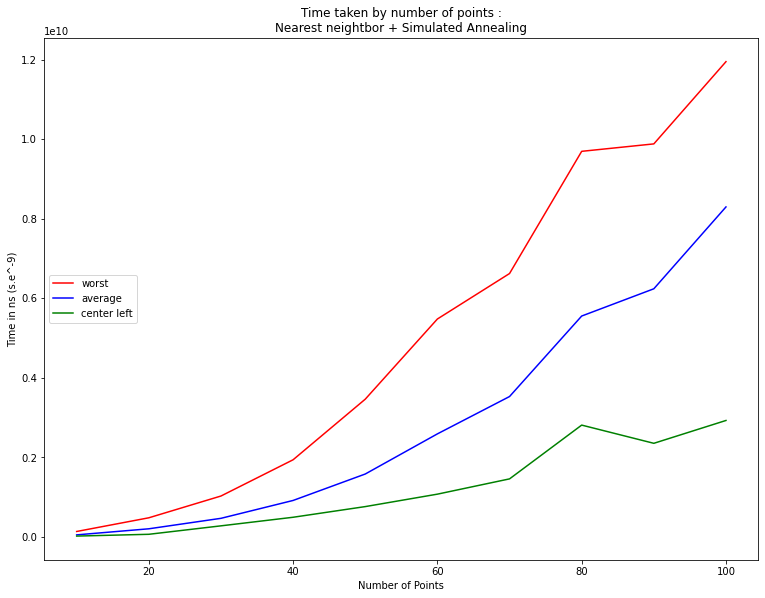

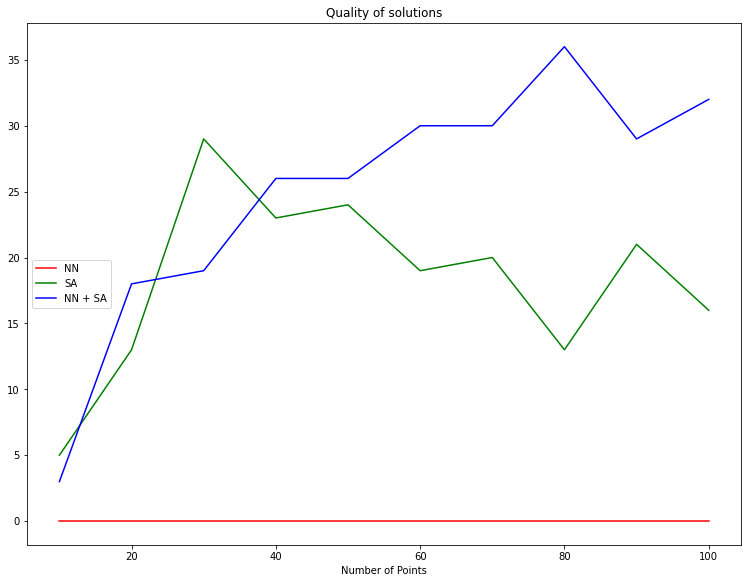

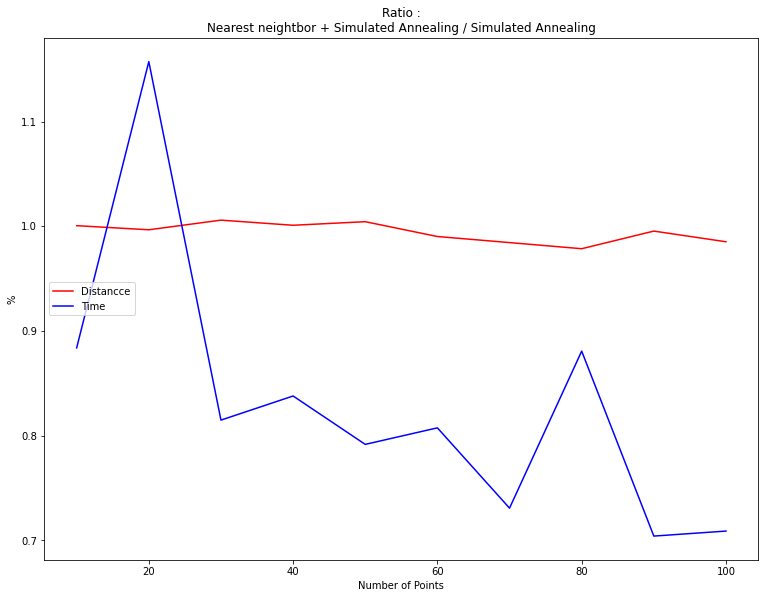

In [26]:
#####################################
# Nearest neightbor
#####################################
WorstNearest = []
AverageNearest = []
BestNearest = []

#####################################
# Recuit simulé
#####################################
WorstRecuit = []
AverageRecuit = []
BestRecuit = []

#####################################
# Win 2
#####################################
Win2Nearest = []
Win2Recuit = []
Exequo2 = []

#####################################
# Nearest neightbor + Recuit simulé
#####################################
WorstCombo = []
AverageCombo = []
BestCombo = []

#####################################
# Win 3
#####################################
Win3Nearest = []
Win3Recuit = []
Win3Combo = []
Win3NearestRecuit = []
Win3RecuitCombo = []
Win3ComboNearest = []
Exequo3 = []

#####################################
# Rapport (NN + RS)/RS
#####################################
RapportDistancce = []
RapportTime = []

for nbSommet in range(1, pointNbChange):
    #####################################
    # Nearest neightbor
    #####################################
    nearest = ResultsNearest[nbSommet-1][0][0]
    worstNearest = nearest
    sumNearest = nearest
    bestNearest = nearest

    #####################################
    # Recuit
    #####################################
    recuit = ResultsRecuit[nbSommet-1][0][0]
    worstRecuit = recuit
    sumRecuit = recuit
    bestRecuit = recuit
    totalRecuit = ResultsRecuit[nbSommet-1][0][1]

    #####################################
    # Win 2
    #####################################
    nearest = ResultsNearest[nbSommet-1][0][1]
    recuit = ResultsRecuit[nbSommet-1][0][1]
    win2Nearest = 0
    win2Recuit = 0
    exequo2 = 0

    if(nearest<recuit):
        win2Nearest += 1
    elif(nearest>recuit):
        win2Recuit += 1
    else:
        exequo2 += 1
    
    #####################################
    # Nearest neightbor + Recuit simulé
    #####################################
    combo = ResultsCombo[nbSommet-1][0][0]
    worstCombo = combo
    sumCombo = combo
    bestCombo = combo
    totalCombo = ResultsCombo[nbSommet-1][0][1]

    #####################################
    # Win 3
    #####################################
    combo = ResultsCombo[nbSommet-1][0][1]
    win3Nearest = 0
    win3Recuit = 0
    win3Combo = 0
    win3NearestRecuit = 0
    win3RecuitCombo = 0
    win3ComboNearest = 0
    exequo3 = 0

    if(combo<nearest and combo<recuit):
        win3Combo += 1
    elif(combo==nearest and combo<recuit):
        win3ComboNearest += 1
    elif(nearest<recuit and nearest<combo):
        win3Nearest += 1
    elif(nearest==recuit and nearest<combo):
        win3NearestRecuit += 1
    elif(recuit<combo and recuit<nearest):
        win3Recuit += 1
    elif(recuit==combo and recuit<nearest):
        win3RecuitCombo += 1
    else:
        exequo3 += 1

    for itération in range(1,nbIteration):
        #####################################
        # Nearest neightbor
        #####################################
        nearest = ResultsNearest[nbSommet-1][itération][0]
        sumNearest += nearest

        if(nearest>worstNearest):
            worstNearest = nearest

        if(nearest<bestNearest):
            bestNearest = nearest

        #####################################
        # Recuit
        #####################################
        recuit = ResultsRecuit[nbSommet-1][itération][0]
        sumRecuit += recuit

        if(recuit>worstRecuit):
            worstRecuit = recuit

        if(recuit<bestRecuit):
            bestRecuit = recuit

        recuit = ResultsRecuit[nbSommet-1][itération][1]
        totalRecuit += recuit

        #####################################
        # Win 2
        #####################################
        nearest = ResultsNearest[nbSommet-1][itération][1]
        
        if(nearest<recuit):
            win2Nearest += 1
        elif(nearest>recuit):
            win2Recuit += 1
        else:
            exequo2 += 1

        #####################################
        # Nearest neightbor + Recuit simulé
        #####################################
        combo = ResultsCombo[nbSommet-1][itération][0]
        sumCombo += combo

        if(combo>worstCombo):
            worstCombo = combo

        if(combo<bestCombo):
            bestCombo = combo

        combo = ResultsCombo[nbSommet-1][itération][1]
        totalCombo += combo
        
        #####################################
        # Win 3
        #####################################
        
        if(combo<nearest and combo<recuit):
            win3Combo += 1
        elif(combo==nearest and combo<recuit):
            win3ComboNearest += 1
        elif(nearest<recuit and nearest<combo):
            win3Nearest += 1
        elif(nearest==recuit and nearest<combo):
            win3NearestRecuit += 1
        elif(recuit<combo and recuit<nearest):
            win3Recuit += 1
        elif(recuit==combo and recuit<nearest):
            win3RecuitCombo += 1
        else:
            exequo3 += 1
    
    #####################################
    # Nearest neightbor
    #####################################
    WorstNearest.append(worstNearest)
    AverageNearest.append(sumNearest/nbIteration)
    BestNearest.append(bestNearest)

    #####################################
    # Recuit
    #####################################
    WorstRecuit.append(worstRecuit)
    AverageRecuit.append(sumRecuit/nbIteration)
    BestRecuit.append(bestRecuit)

    #####################################
    # Win 2
    #####################################
    Win2Nearest.append(win2Nearest)
    Win2Recuit.append(win2Recuit)
    Exequo2.append(exequo2)

    #####################################
    # Nearest neightbor + Recuit simulé
    #####################################
    WorstCombo.append(worstCombo)
    AverageCombo.append(sumCombo/nbIteration)
    BestCombo.append(bestCombo)

    #####################################
    # Win 3
    #####################################
    Win3Nearest.append(win3Nearest)
    Win3Recuit.append(win3Recuit)
    Win3Combo.append(win3Combo)
    Win3NearestRecuit.append(win3NearestRecuit)
    Win3RecuitCombo.append(win3RecuitCombo)
    Win3ComboNearest.append(win3ComboNearest)
    Exequo3.append(exequo3)

    #####################################
    # Rapport (NN + RS)/RS
    #####################################
    RapportDistancce.append(totalCombo/totalRecuit)
    RapportTime.append(sumCombo/sumRecuit)

absise = range(1*step, pointNbChange*step, step)

#####################################
# Nearest neightbor
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, WorstNearest, "r", label="worst")
plt.plot(absise, AverageNearest, "b", label="average")
plt.plot(absise, BestNearest, "g", label="best")
plt.legend(loc="center left")
plt.title("Time taken by number of points :\nNearest Neightbor")
plt.xlabel("Number of Points")
plt.ylabel("Time in ns (s.e^-9)")
plt.show()

#####################################
# Recuit
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, WorstRecuit, "r", label="worst")
plt.plot(absise, AverageRecuit, "b", label="average")
plt.plot(absise, BestRecuit, "g", label="best")
plt.legend(loc="center left")
plt.title("Time taken by number of points :\nSimulated Annealing")
plt.xlabel("Number of Points")
plt.ylabel("Time in ns (s.e^-9)")
plt.show()

#####################################
# Win 2
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, Win2Nearest, "r", label="NN")
plt.plot(absise, Win2Recuit, "g", label="SA")
plt.legend(loc="center left")
plt.title("Quality of solutions")
plt.xlabel("Number of Points")
plt.ylabel("")
plt.show()

#####################################
# Nearest neightbor + Recuit simulé
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, WorstCombo, "r", label="worst")
plt.plot(absise, AverageCombo, "b", label="average")
plt.plot(absise, BestCombo, "g", label="center left")
plt.legend(loc="center left")
plt.title("Time taken by number of points :\nNearest neightbor + Simulated Annealing")
plt.xlabel("Number of Points")
plt.ylabel("Time in ns (s.e^-9)")
plt.show()

#####################################
# Win 3
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, Win3Nearest, "r", label="NN")
plt.plot(absise, Win3Recuit, "g", label="SA")
plt.plot(absise, Win3Combo, "b", label="NN + SA")
plt.legend(loc="center left")
plt.title("Quality of solutions")
plt.xlabel("Number of Points")
plt.ylabel("")
plt.show()

#####################################
# Rapport (NN + RS)/RS
#####################################
plt.figure(figsize=(12.8,9.6))
plt.plot(absise, RapportDistancce, "r", label="Distancce")
plt.plot(absise, RapportTime, "b", label="Time")
plt.legend(loc="center left")
plt.title("Ratio :\nNearest neightbor + Simulated Annealing / Simulated Annealing")
plt.xlabel("Number of Points")
plt.ylabel("%")
plt.show()
